In [1]:
!pip install meteocalc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from tqdm import tqdm_notebook as tqdm
import datetime
from meteocalc import feels_like, Temp
from sklearn import metrics
import gc
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

  Created wheel for meteocalc: filename=meteocalc-1.1.0-cp36-none-any.whl size=8196 sha256=209517ab39432a25fdae7e23625dba4df58214caba981aa897ddc706a6061df4
  Stored in directory: /tmp/.cache/pip/wheels/9e/34/13/83d36ecc28837e3c2a5b696542e697538e7c1025382f4ded55
Successfully built meteocalc
/kaggle/input/ashrae-leak-data-station/leak.feather
/kaggle/input/ashrae-leak-data-station/__notebook__.ipynb
/kaggle/input/ashrae-leak-data-station/__results__.html
/kaggle/input/ashrae-leak-data-station/__output__.json
/kaggle/input/ashrae-leak-data-station/__resultx__.html
/kaggle/input/ashrae-leak-data-station/custom.css
/kaggle/input/ashrae-leak-data-station/__results___files/__results___9_11.png
/kaggle/input/ashrae-leak-data-station/__results___files/__results___25_5.png
/kaggle/input/ashrae-leak-data-station/__results___files/__results___9_10.png
/kaggle/input/ashrae-leak-data-station/__results___files/__results___9_2.png
/kaggle/input/ashrae-leak-data-station/__results___files/__results___9_

# Load Data

In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
train_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/train.csv')
building_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')
weather_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_train.csv')

Referring to the following discussions. We have filtered the data in the next step

* Ref1. https://www.kaggle.com/c/ashrae-energy-prediction/discussion/114830#latest-680086
* Ref2. https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588 

In [4]:
# Ref 1
#train_df = train_df [ train_df['building_id'] != 1099 ]
# Ref 2
#train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [5]:
# eliminate bad rows
bad_rows = pd.read_csv('/kaggle/input/ashrae-simple-data-cleanup-lb-1-08-no-leaks/rows_to_drop.csv')
train_df.drop(bad_rows.loc[:, '0'], inplace = True)
train_df.reset_index(drop = True, inplace = True)

In [6]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
    
    def get_meteorological_features(data):
        def calculate_rh(df):
            df['relative_humidity'] = 100 * (np.exp((17.625 * df['dew_temperature']) / (243.04 + df['dew_temperature'])) / np.exp((17.625 * df['air_temperature'])/(243.04 + df['air_temperature'])))
        def calculate_fl(df):
            flike_final = []
            flike = []
            # calculate Feels Like temperature
            for i in range(len(df)):
                at = df['air_temperature'][i]
                rh = df['relative_humidity'][i]
                ws = df['wind_speed'][i]
                flike.append(feels_like(Temp(at, unit = 'C'), rh, ws))
            for i in range(len(flike)):
                flike_final.append(flike[i].f)
            df['feels_like'] = flike_final
            del flike_final, flike, at, rh, ws
        calculate_rh(data)
        calculate_fl(data)
        return data

    weather_df = get_meteorological_features(weather_df)
    return weather_df

In [7]:
def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    
    df['month'] = df['timestamp'].dt.month
    df['month'].replace((1, 2, 3, 4), 1, inplace = True)
    df['month'].replace((5, 6, 7, 8), 2, inplace = True)
    df['month'].replace((9, 10, 11, 12), 3, inplace = True)
  
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # Remove Unused Columns
    drop = ["timestamp"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [8]:
# weather manipulation
weather_df = fill_weather_dataset(weather_df)

# memory reduction
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

# merge data
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del weather_df
gc.collect()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


Memory usage of dataframe is 586.85 MB
Memory usage after optimization is: 165.43 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 11.80 MB
Memory usage after optimization is: 3.19 MB
Decreased by 72.9%


0

In [9]:
# feature engineering
train_df = features_engineering(train_df)

# transform target variable
train_df['meter_reading'] = np.log1p(train_df["meter_reading"])

In [10]:
# declare target, categorical and numeric columns
target = 'meter_reading'
categorical = ['building_id', 'site_id', 'primary_use', 'meter','dayofweek']
numeric_cols = [col for col in train_df.columns if col not in categorical + [target, 'timestamp', 'month']]
features = categorical + numeric_cols

In [11]:
features = [f for f in features if f!="wind_speed"]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.22131	valid_1's rmse: 1.22377
[50]	training's rmse: 0.90407	valid_1's rmse: 0.92453
[75]	training's rmse: 0.754376	valid_1's rmse: 0.792855
[100]	training's rmse: 0.688043	valid_1's rmse: 0.746939
[125]	training's rmse: 0.654443	valid_1's rmse: 0.729534
[150]	training's rmse: 0.633003	valid_1's rmse: 0.722653
[175]	training's rmse: 0.616233	valid_1's rmse: 0.718253
[200]	training's rmse: 0.603487	valid_1's rmse: 0.716259
[225]	training's rmse: 0.591543	valid_1's rmse: 0.714562
[250]	training's rmse: 0.581322	valid_1's rmse: 0.714184
[275]	training's rmse: 0.572471	valid_1's rmse: 0.714074
[300]	training's rmse: 0.565196	valid_1's rmse: 0.713966
[325]	training's rmse: 0.559097	valid_1's rmse: 0.714096
[350]	training's rmse: 0.553461	valid_1's rmse: 0.714329
Early stopping, best iteration is:
[306]	training's rmse: 0.56351	valid_1's rmse: 0.713909
Training until validation scores don't improve for 50 rou

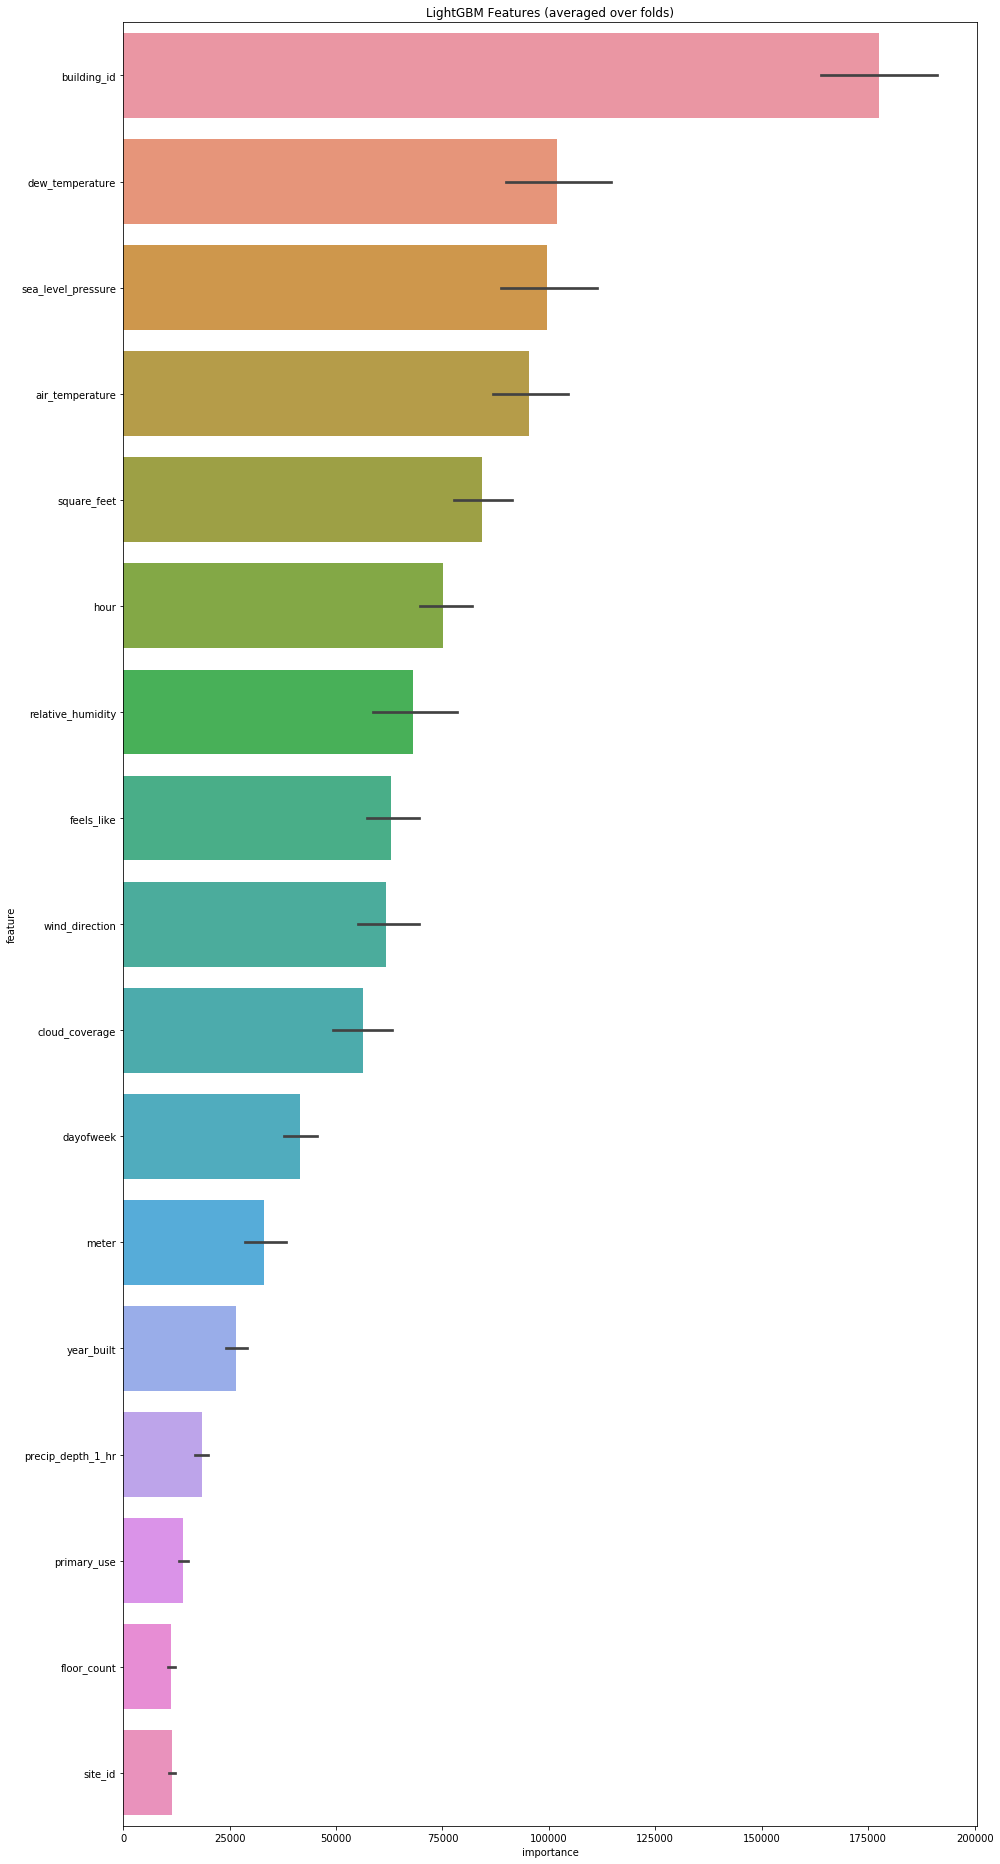

In [12]:
import seaborn as sns

def run_lgbm(train, cat_features = categorical, num_rounds = 20000, folds = 5):
    kf = StratifiedKFold(n_splits=folds, shuffle=False, random_state=2319)
    models = []
    feature_importance_df = pd.DataFrame()

    param =  {'num_leaves': 3160,
             'objective': 'regression',
             'learning_rate': 0.03,
             'boosting': 'gbdt',
             'subsample': 0.5,
             'feature_fraction': 0.7,
             'n_jobs': -1,
             'seed': 50,
             'metric': 'rmse'
              }
    
    oof = np.zeros(len(train))
  
    for tr_idx, val_idx in tqdm(kf.split(train_df,train_df['month']), total = folds):
        tr_x, tr_y = train[features].iloc[tr_idx], train[target].iloc[tr_idx]
        vl_x, vl_y = train[features].iloc[val_idx], train[target].iloc[val_idx]
        tr_data = lgb.Dataset(tr_x, label = tr_y,  categorical_feature = categorical)
        vl_data = lgb.Dataset(vl_x, label = vl_y,  categorical_feature = categorical)
        clf = lgb.train(param, tr_data, num_rounds, valid_sets = [tr_data, vl_data], verbose_eval = 25, 
                        early_stopping_rounds = 50)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        models.append(clf)
        oof[val_idx] = clf.predict(vl_x)
        gc.collect()
    score = np.sqrt(metrics.mean_squared_error(train[target], np.clip(oof, a_min=0, a_max=None)))
    print('Our oof cv is :', score)
    
    cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(14,26))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('LightGBM Features (averaged over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

    return models
models = run_lgbm(train_df)

In [13]:
# read test
test_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/test.csv')
row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)
test_df = reduce_mem_usage(test_df)

# merge with building info
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')
del building_df
gc.collect()

# fill test weather data
weather_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv')
weather_df = fill_weather_dataset(weather_df)
weather_df = reduce_mem_usage(weather_df)

# merge weather data
test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])
del weather_df
gc.collect()

# feature engineering
test_df = features_engineering(test_df)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.59 MB
Decreased by 79.1%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


Memory usage of dataframe is 23.53 MB
Memory usage after optimization is: 11.18 MB
Decreased by 52.5%


In [14]:
def predictions(models, iterations = 120):
    # split test data into batches
    set_size = len(test_df)
    batch_size = set_size // iterations
    meter_reading = []
    for i in tqdm(range(iterations)):
        pos = i*batch_size
        fold_preds = [np.expm1(model.predict(test_df[features].iloc[pos : pos+batch_size])) for model in models]
        meter_reading.extend(np.mean(fold_preds, axis=0))

    print(len(meter_reading))
    assert len(meter_reading) == set_size
    submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
    submission['meter_reading'] = np.clip(meter_reading, a_min=0, a_max=None) # clip min at zero
    submission.to_csv('submission_SK_drop_ws.csv', index=False)
    print('We are done!')
predictions(models)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



41697600
We are done!
